# 複素ISTAにFFTを利用する

このプログラムは、ライブラリcomplexlib.pyを利用するので、手元で実行してください。

問題設定の概要は次の通りです。

* 通信路は複素AWGN通信路
* 送信信号は8PSK
* 送信側ではIFFTをかける
* 信号長は$n$

本コードの実行のためには、tqdmが必要です(インストールされてない場合は、インストールしてください)。
本コードはC-TISTA(Takabe and Wadayama, 2019)をベースにしています。詳細については
下記をご覧ください。

https://arxiv.org/abs/1904.07409

## ライブラリのインポート

In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import complexlib as c

## デバイスの指定

* GPUを利用する場合には'cuda'と指定する
* CPUを利用する場合には'cpu'と指定する

In [2]:
device = torch.device('cpu') # 'cpu' or 'cuda'

## グローバル定数の設定

In [10]:
n = 128 # 信号長
max_itr = 10 # ISTAの反復回数
mbs   = 20 # ミニバッチサイズ
adam_lr = 0.001 # Adamの学習率

## 信号点配置の定義 (この例では8PSKを仮定)

In [11]:
# QPSK
#M = 4
#point = torch.tensor([
#    [0.70107, 0.70107],
#    [0.70107, -0.70107],
#    [-0.70107, 0.70107],
#    [-0.70107, -0.70107],
#])

# 8PSK
M = 8 # 信号点数
point = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [-1.0, 0.0],
    [0.0,-1.0],
    [0.70107, 0.70107],
    [0.70107, -0.70107],
    [-0.70107, 0.70107],
    [-0.70107, -0.70107],
])

## ミニバッチ生成関数

In [12]:
def gen_minibatch():
    re = []
    im = []
    for i in range(mbs):
        rindex = torch.randint(M, (1,n)).view(n)
        tmp = torch.index_select(point, 0, rindex)
        re.append(tmp[:,0].to(device))
        im.append(tmp[:,1].to(device))
    return (torch.stack(re), torch.stack(im)) 

## 学習可能な複素ISTA クラス

In [13]:
class C_ISTA(nn.Module):
    def __init__(self, max_itr):
        super(C_ISTA, self).__init__()
        self.beta = nn.Parameter(0.1*torch.ones(max_itr)) # 学習可能ステップサイズ
        self.lam = nn.Parameter(0.1*torch.ones(max_itr)) # 収縮関数制御パラメータ
    def c_shrinkage(self, x, var_mat):
        eps = 1e-10
        num_re = torch.zeros(mbs, n).to(device)
        num_im = torch.zeros(mbs, n).to(device)
        deno   = torch.zeros(mbs, n).to(device) + eps
        for i in range(M):
            r = (x[0] - point[i][0])**2 + (x[1] - point[i][1])**2
            f = torch.exp(-r/var_mat)
            num_re += point[i][0] * f
            num_im += point[i][1] * f
            deno += f
        return (num_re/deno, num_im/deno)
    def forward(self, y, num_itr):
        s = c.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            tmp = c.sub(y, c.ifft(s))
            tmp2 = c.scalar_mul(self.beta[i], c.fft(tmp))
            r = c.add(s, tmp2)
            s = self.c_shrinkage(r, self.lam[i])
        return s

## インスタンス作成

In [14]:
model = C_ISTA(max_itr).to(device)
opt   = optim.Adam(model.parameters(), lr=adam_lr) 
loss_func = nn.MSELoss()

## 平均エネルギーの測定

In [16]:
Es = 0.0
for i in range(100):
    x = gen_minibatch()
    t = c.ifft(x)
    Es += ((c.norm(t)**2).sum()/(mbs*n)).detach().cpu().item()
Es = Es / 100
print(Es)

0.9914727967977524


## SN比の設定

In [17]:
snr = 15.0
sigma = math.sqrt(Es * 10.0**(-snr/10.0))
print('sigma = ', sigma)

sigma =  0.1770681302769698


## 訓練ループ

In [18]:
for gen in tqdm(range(max_itr)):
    for i in range(200):
        x = gen_minibatch()
        w = c.normal(mbs, n, sigma)
        t = c.ifft(x)
        y = c.add(t, w)
        opt.zero_grad()
        x_hat = model(y, gen + 1)
        loss  = loss_func(x_hat[0], x[0]) + loss_func(x_hat[1], x[1])
        loss.backward()
        opt.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  8.06s/it]


## 学習可能ISTAの試験再現のための準備

In [19]:
def gen_word():
    rindex = torch.randint(M, (1,n)).view(n)
    tmp = torch.index_select(point, 0, rindex)
    return rindex, (tmp[:,0].view(1,n).to(device), tmp[:,1].view(1,n).to(device)) 
mbs = 1
rind, x = gen_word()
w = c.normal(mbs, n, sigma)
t = c.ifft(x)
y = c.add(t, w)
with torch.no_grad():
    s = model(y, max_itr)
x_re = x[0][0].cpu().numpy()
x_im = x[1][0].cpu().numpy()
s_re = s[0][0].cpu().detach().numpy()
s_im = s[1][0].cpu().detach().numpy()

## 送信信号と再現信号の実部の表示

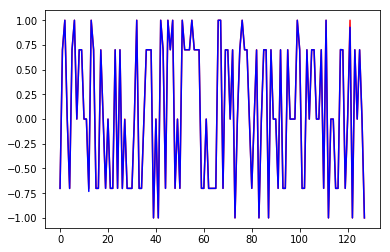

In [20]:
plt.plot(range(n), x_re, color="red")
plt.plot(range(n), s_re, color="blue")

## 送信信号と再現信号の虚部の表示

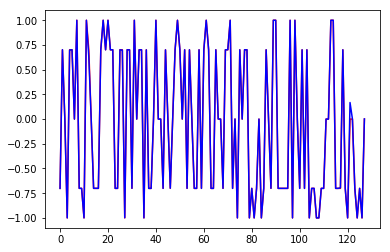

In [21]:
plt.plot(range(n), x_im, color="red")
plt.plot(range(n), s_im, color="blue")

## ZF推定(FFTの実行による)推定結果の表示 (実部)

In [22]:
s = c.fft(y)
t_re = s[0][0].cpu().detach().numpy()
t_im = s[1][0].cpu().detach().numpy()

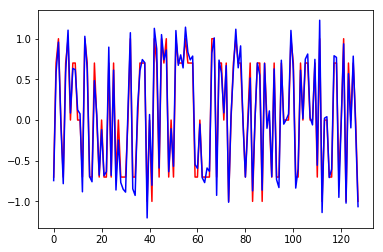

In [23]:
plt.plot(range(n), x_re, color="red")
plt.plot(range(n), t_re, color="blue")

## ZF推定(FFTの実行による)推定結果の表示 (虚部)

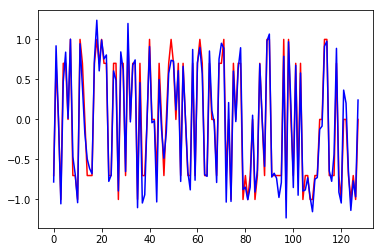

In [24]:
plt.plot(range(n), x_im, color="red")
plt.plot(range(n), t_im, color="blue")

## 送信信号の散布図

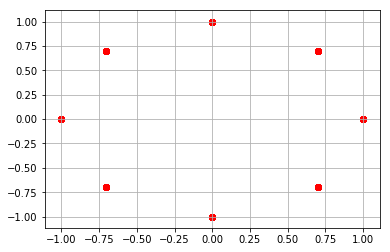

In [25]:
plt.grid()
plt.scatter(x_re, x_im, color="red")

## 学習可能ISTAによる推定信号の散布図

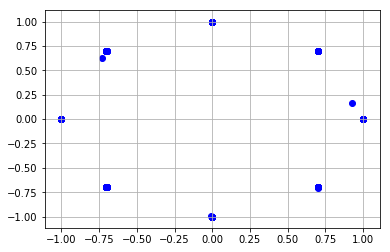

In [26]:
plt.grid()
plt.scatter(s_re, s_im, color="blue")

## FFT(ZF)推定による推定信号の散布図

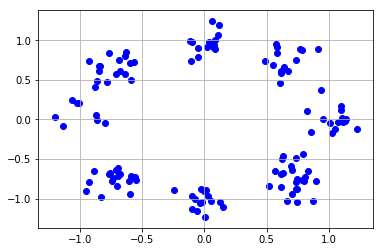

In [27]:
plt.grid()
plt.scatter(t_re, t_im, color="blue")